# **Importing all the necessary libraries**

In [ ]:
# Data manipulation and computations
import numpy as np
import pandas as pd


# Visualization
import matplotlib.pyplot as plt

# For working with files
import os

# OpenCV library, a popular computer vision library in Python. It is used for image and video processing, including reading and manipulating image files
import cv2

# Used to display progress bars for tasks that may take some time to complete
from tqdm import tqdm


# For generating psudo random numbers
import random

# For splitting the data
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Set random seed for reproducibility (Ensures consistent random numbers)
random.seed(42)

# Importing the first model VGG19
from tensorflow.keras.applications.vgg19 import VGG19
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten,Dense

'''
 Use this if you need to install or upgrade tenserflow (!pip install --upgrade tensorflow)
 ImageDataGenerator -> resizing and normalizing images
 load_img -> used to load an image file into a PIL (Python Imaging Library) image
 img_to_array -> converts a PIL image or a (H, W, C) numpy array into a (C, H, W) numpy array

'''
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

# For assessing model performance
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Used at the end to load the model after saving it
from tensorflow.keras.models import load_model


# **Loading the datasets from kaggle into google colab**

In [ ]:
# Uncomment all these if you don't have the data loaded in google colab, and don't forget to upload the kaggle key

'''

!pip install kaggle
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!mkdir -p ocular-disease-recognition
!kaggle datasets download -d andrewmvd/ocular-disease-recognition-odir5k -p ocular-disease-recognition
!unzip -q ocular-disease-recognition/ocular-disease-recognition-odir5k.zip

'''

data = pd.read_csv("full_df.csv")
data.head(3)

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg


# **Exploration**

In [ ]:
# Checking for missing data

missing_values = data.isnull().sum()

print("Missing values in the entire DataFrame:")
print(missing_values)

Missing values in the entire DataFrame:
ID                           0
Patient Age                  0
Patient Sex                  0
Left-Fundus                  0
Right-Fundus                 0
Left-Diagnostic Keywords     0
Right-Diagnostic Keywords    0
N                            0
D                            0
G                            0
C                            0
A                            0
H                            0
M                            0
O                            0
filepath                     0
labels                       0
target                       0
filename                     0
dtype: int64


In [ ]:
# Check for duplicates

any_duplicates = data.duplicated().any()
any_duplicates

False

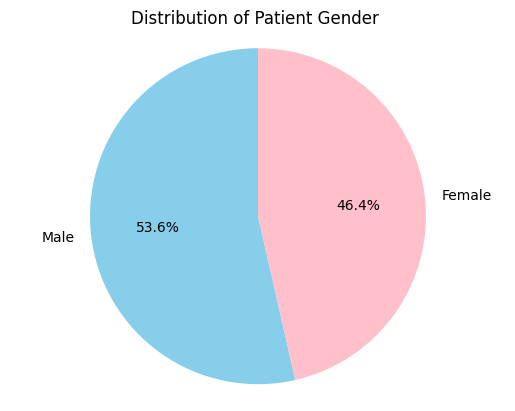

In [ ]:
# Distribution of patient gender

gender_counts = data['Patient Sex'].value_counts()
colors=['skyblue','pink']
plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', startangle=90,colors=colors)

plt.title('Distribution of Patient Gender ')

plt.axis('equal')
plt.show()


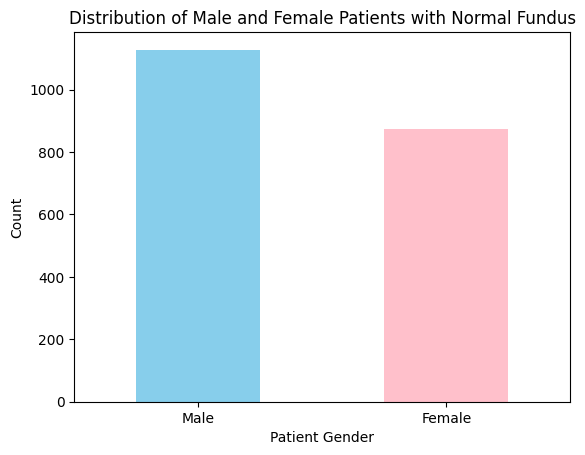

In [ ]:
# Distribution of male and female with normal funuds

filtered_data = data[(data['Left-Diagnostic Keywords'] == 'normal fundus') & (data['Right-Diagnostic Keywords'] == 'normal fundus')]

gender_counts = filtered_data['Patient Sex'].value_counts()
colors=['skyblue','pink']
gender_counts.plot(kind='bar', rot=0,color=colors)

plt.xlabel('Patient Gender')
plt.ylabel('Count')
plt.title('Distribution of Male and Female Patients with Normal Fundus')

plt.show()

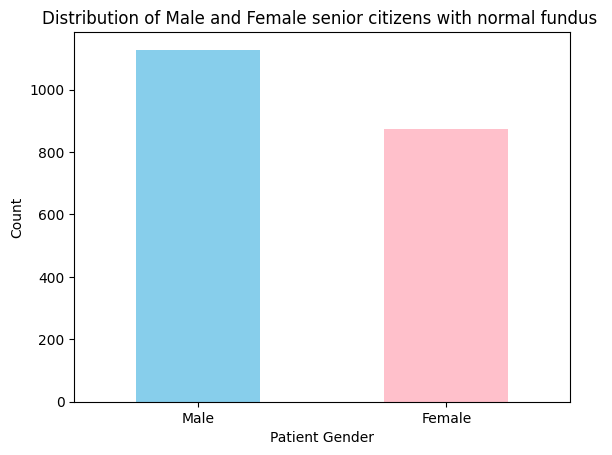

In [ ]:
# Distribution of male and female with normal funuds && senior (age >= 65)

senior_citizens = data[(data['Left-Diagnostic Keywords'] == 'normal fundus') & (data['Right-Diagnostic Keywords'] == 'normal fundus') &(data['Patient Age'] >= 65)]
colors=['skyblue','pink']
gender_counts.plot(kind='bar', rot=0,color=colors)

plt.xlabel('Patient Gender')
plt.ylabel('Count')
plt.title('Distribution of Male and Female senior citizens with normal fundus ')
plt.show()

# **Preparation**

In [ ]:
# Helper function to check if the keyword for a class exist in diagnostic columns

def has_condn(term, text):
    if term in text:
        return 1
    else:
        return 0

In [ ]:
# For each disease, combine left and right images, add two columns  for each disease to the data
''' We used the diagnostic columns instead of labels because they wern't strict
    some patients had 1 in more than one position look at patient with id = 2
    0	1	0	0	0	0	0	1
'''

def process_dataset(data):

    # Extracting all left and right images ids with the same diagnosis keywords
    data["left_cataract"] = data["Left-Diagnostic Keywords"].apply(lambda x: has_condn("cataract",x))
    data["right_cataract"] = data["Right-Diagnostic Keywords"].apply(lambda x: has_condn("cataract",x))

    data["LD"] = data["Left-Diagnostic Keywords"].apply(lambda x: has_condn("non proliferative retinopathy",x)) # non-proliferative diabetic retinopathy
    data["RD"] = data["Right-Diagnostic Keywords"].apply(lambda x: has_condn("non proliferative retinopathy",x))

    data["LG"] = data["Left-Diagnostic Keywords"].apply(lambda x: has_condn("glaucoma",x))
    data["RG"] = data["Right-Diagnostic Keywords"].apply(lambda x: has_condn("glaucoma",x))

    data["LH"] = data["Left-Diagnostic Keywords"].apply(lambda x: has_condn("hypertensive",x))
    data["RH"] = data["Right-Diagnostic Keywords"].apply(lambda x: has_condn("hypertensive",x))

    data["LM"] = data["Left-Diagnostic Keywords"].apply(lambda x: has_condn("myopia",x))
    data["RM"] = data["Right-Diagnostic Keywords"].apply(lambda x: has_condn("myopia",x))

    data["LA"] = data["Left-Diagnostic Keywords"].apply(lambda x: has_condn("macular degeneration",x))
    data["RA"] = data["Right-Diagnostic Keywords"].apply(lambda x: has_condn("macular degeneration",x))

    data["LO"] = data["Left-Diagnostic Keywords"].apply(lambda x: has_condn("drusen",x))
    data["RO"] = data["Right-Diagnostic Keywords"].apply(lambda x: has_condn("drusen",x))


    # Using the ids columns we created to create an array, a sample of each class

    left_cataract_images = data.loc[(data.C ==1) & (data.left_cataract == 1)]["Left-Fundus"].values
    right_cataract_images = data.loc[(data.C == 1) & (data.right_cataract == 1)]["Right-Fundus"].values

    left_normal = data.loc[(data.N == 1) & (data["Left-Diagnostic Keywords"] == "normal fundus")]['Left-Fundus'].sample(350,random_state=42).values
    right_normal = data.loc[(data.N == 1) & (data["Right-Diagnostic Keywords"] == "normal fundus")]['Right-Fundus'].sample(350,random_state=42).values

    left_diab = data.loc[(data.D == 1) & (data.LD == 1)]["Left-Fundus"].sample(350, random_state=42).values
    right_diab = data.loc[(data.D == 1) & (data.RD == 1)]["Right-Fundus"].sample(350, random_state=42).values

    left_glaucoma = data.loc[(data.G == 1) & (data.LG == 1)]["Left-Fundus"].values
    right_glaucoma = data.loc[(data.G == 1) & (data.RG == 1)]["Right-Fundus"].values

    left_hyper = data.loc[(data.H == 1) & (data.LH == 1)]["Left-Fundus"].values
    right_hyper = data.loc[(data.H == 1) & (data.RH == 1)]["Right-Fundus"].values

    left_myopia = data.loc[(data.M == 1) & (data.LM == 1)]["Left-Fundus"].values
    right_myopia = data.loc[(data.M == 1) & (data.RM == 1)]["Right-Fundus"].values

    left_age = data.loc[(data.A == 1) & (data.LA == 1)]["Left-Fundus"].values
    right_age = data.loc[(data.A == 1) & (data.RA == 1)]["Right-Fundus"].values

    left_other = data.loc[(data.O == 1) & (data.LO == 1)]["Left-Fundus"].values
    right_other = data.loc[(data.O == 1) & (data.RO == 1)]["Right-Fundus"].values


    '''Combine both arrays left & right,
       now we have a set of ids for each disease, each id (row) corresponds to a pair of eyes'''

    normalones = np.concatenate((left_normal, right_normal), axis = 0);
    cataractones = np.concatenate((left_cataract_images, right_cataract_images), axis = 0);
    diabones = np.concatenate((left_diab, right_diab), axis = 0);
    glaucoma = np.concatenate((left_glaucoma, right_glaucoma), axis = 0);
    hyper = np.concatenate((left_hyper, right_hyper), axis = 0);
    myopia = np.concatenate((left_myopia, right_myopia), axis = 0);
    age = np.concatenate((left_age, right_age), axis=0);
    other = np.concatenate((left_other, right_other), axis = 0);

    # These are used later to fetch all the images from the folder
    return normalones, cataractones, diabones, glaucoma, hyper, myopia, age, other;

In [ ]:
# Call the process_dataset function and get the arrays representing left and right images of each disease
# (::) indicating that this is a pair not a single eye

normal , cataract , diab, glaucoma , hyper , myopia , age, other = process_dataset(data);

print("Dataset stats:-\n")
print("Normal ::" , len(normal))
print("Cataract ::" , len(cataract))
print("Diabetes ::" , len(diab))
print("Glaucoma ::" , len(glaucoma))
print("Hypertension ::" , len(hyper))
print("Myopia ::" , len(myopia))
print("Age Issues ::" , len(age))
print("Other ::" , len(other))



Dataset stats:-

Normal :: 700
Cataract :: 594
Diabetes :: 700
Glaucoma :: 616
Hypertension :: 382
Myopia :: 479
Age Issues :: 551
Other :: 336


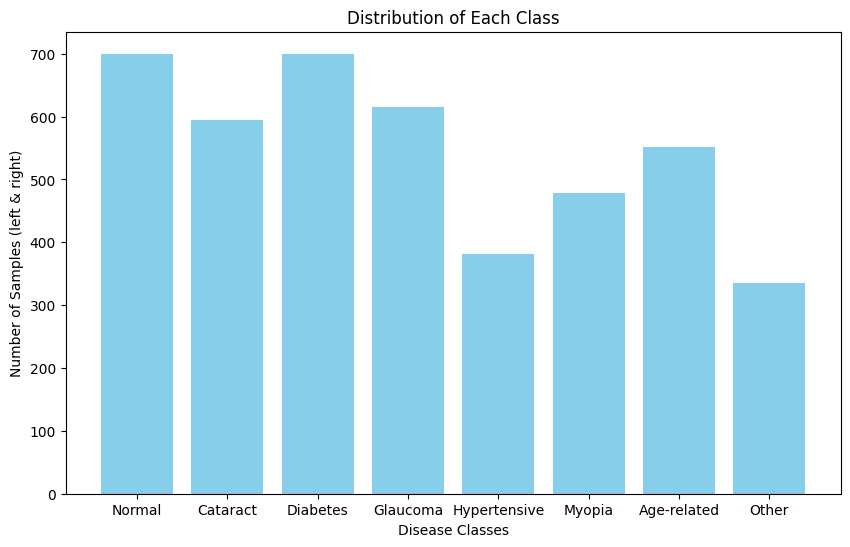

In [ ]:
# The distribution of all diseases

class_labels = ['Normal', 'Cataract', 'Diabetes', 'Glaucoma', 'Hypertensive', 'Myopia', 'Age-related', 'Other']
class_counts = [len(normal), len(cataract), len(diab), len(glaucoma), len(hyper), len(myopia), len(age), len(other)]

# Plotting the bar chart
plt.figure(figsize=(10, 6))
plt.bar(class_labels, class_counts, color='skyblue')
plt.title('Distribution of Each Class')
plt.xlabel('Disease Classes')
plt.ylabel('Number of Samples (left & right)')
plt.show()

In [ ]:
# Defining dataset_generator function to use it to fill a dataset with equal sized images

dataset_dir = "preprocessed_images"
image_size = 224
dataset = []

def dataset_generator(imagecategory , label):
    for img in tqdm(imagecategory):
        imgpath = os.path.join(dataset_dir, img);

        # Try to read, resize, and change the color mode
        try:
            image = cv2.imread(imgpath, cv2.IMREAD_COLOR)
            image = cv2.resize(image, (image_size, image_size))
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
        # If an exception happens (the image in the csv file doesn't exist in the folder) continue to the next image
        except:
            continue;
        dataset.append([np.array(image), np.array(label)]);
    random.shuffle(dataset);

    return dataset;

In [ ]:
# Generating images for each class using the ids arrays we created earlier,
# Storing them in a dataset with the labels to use in the model later
# Each class has a set of rows not, each row is a pair of eye for that class

dataset = dataset_generator(normal,0)
dataset = dataset_generator(cataract,1)
dataset = dataset_generator(diab,2)
dataset = dataset_generator(glaucoma,3)
dataset = dataset_generator(hyper,4)
dataset = dataset_generator(myopia,5)
dataset = dataset_generator(age,6)
dataset = dataset_generator(other,7)

print(f'\nNumber of images we have for all classes: {len(dataset)}')

100%|██████████| 336/336 [00:01<00:00, 276.08it/s]


Number of images we have for all classes: 4324


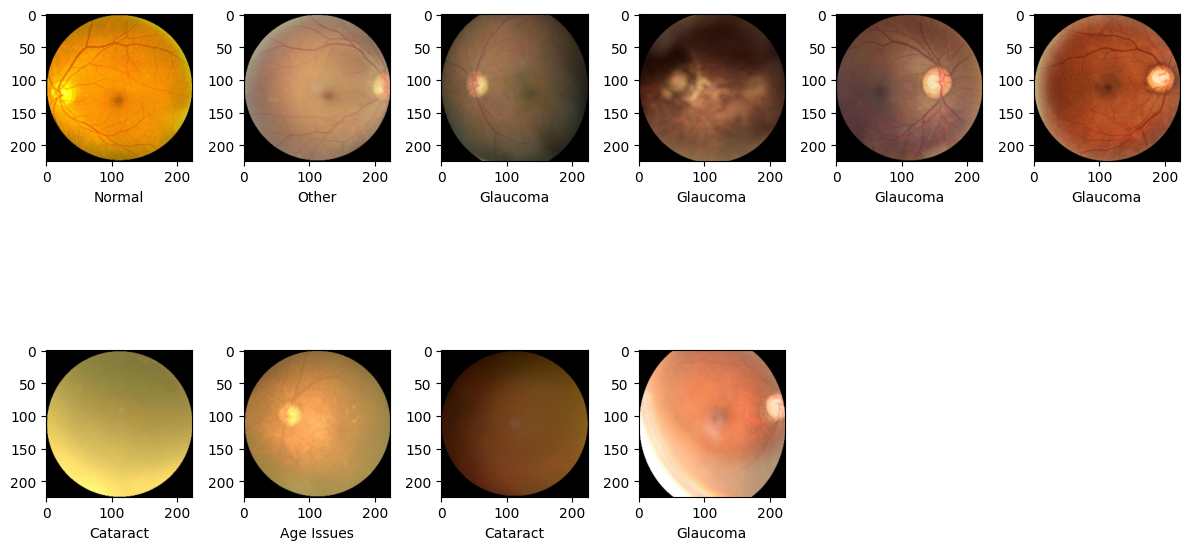

In [ ]:
# Visualizing a random sample of the dataset

plt.figure(figsize=(12,7))
for i in range(10):
    sample = random.choice(range(len(dataset)))
    image = dataset[sample][0]
    category = dataset[sample][1]

    if category== 0:
        label = "Normal"
    elif category == 1 :
        label = "Cataract"
    elif category == 2:
        label = "Diabetes"
    elif category == 3:
        label = "Glaucoma"
    elif category == 4:
        label = "Hypertension"
    elif category == 5:
        label = "Myopia"
    elif category == 6:
        label = "Age Issues"
    else:
        label = "Other"

    plt.subplot(2,6,i+1)
    plt.imshow(image)
    plt.xlabel(label)
plt.tight_layout()

In [ ]:
# Divide the dataset into 2 sets predictors and target...
# Here predictors would be the image and target would be the label

# Getting the images
train_x = np.array([i[0] for i in dataset]).reshape(-1, image_size, image_size, 3);

# Getting the labels of the images
train_y = np.array([i[1] for i in dataset])

# Splitting the dataset
x_train , x_test , y_train, y_test = train_test_split(train_x, train_y, test_size=0.2)


# One-hot encoding the labels (0,1..7)
y_train_cat = to_categorical(y_train, num_classes=8)
y_test_cat = to_categorical(y_test, num_classes = 8)


# **CNN Model - with VGG19 Architecture**

In [ ]:
# Define the model's architecture

# Load the VGG19 model with ImageNet weights and exclude the top layer
vgg = VGG19(weights="imagenet", include_top=False, input_shape=(image_size, image_size, 3))

# Freeze the weights of the VGG19 layers, to transfer the knowledge of the pretrained weights
for layer in vgg.layers:
    layer.trainable = False

# Create a Sequential model
model = Sequential([
    vgg,
    Flatten(),

    Dense(256, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    Dense(256, activation="relu"),
    tf.keras.layers.BatchNormalization(),

    Dense(8, activation="softmax")
])

# Display the model summary
model.summary()


80134624/80134624 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 256)               6422784   
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 batch_normalization_1 (Bat  (None, 256)               10

In [ ]:
# Train the model with adam optimizer, 15 epochs & a batch size of 32

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
history = model.fit(x_train, y_train_cat, batch_size=32, epochs=15)
print(history)

Epoch 1/15
109/109 [==============================] - 28s 154ms/step - loss: 1.4618 - accuracy: 0.4929
Epoch 2/15
109/109 [==============================] - 16s 144ms/step - loss: 0.7712 - accuracy: 0.7317
Epoch 3/15
109/109 [==============================] - 16s 147ms/step - loss: 0.5421 - accuracy: 0.8303
Epoch 4/15
109/109 [==============================] - 17s 152ms/step - loss: 0.3929 - accuracy: 0.8907
Epoch 5/15
109/109 [==============================] - 17s 158ms/step - loss: 0.3403 - accuracy: 0.8994
Epoch 6/15
109/109 [==============================] - 17s 160ms/step - loss: 0.2516 - accuracy: 0.9344
Epoch 7/15
109/109 [==============================] - 18s 162ms/step - loss: 0.2314 - accuracy: 0.9300
Epoch 8/15
109/109 [==============================] - 17s 160ms/step - loss: 0.2262 - accuracy: 0.9352
Epoch 9/15
109/109 [==============================] - 17s 156ms/step - loss: 0.2371 - accuracy: 0.9324
Epoch 10/15
109/109 [==============================] - 17s 158ms/step - l

In [ ]:
# Evaluaing the model, performance on test data

loss, accuracy = model.evaluate(x_test, y_test_cat)
print("Accuracy:", accuracy)

28/28 [==============================] - 6s 186ms/step - loss: 1.1176 - accuracy: 0.7676
Accuracy: 0.7676300406455994


In [ ]:
# Visualizing the attempts of prediction on the test data + some info about the performance

# Convert probabilities to class labels
y_pred = [np.argmax(np.array(i)).astype("int32") for i in model.predict(x_test)]

# True labels are in y_test_cat
y_true = [np.argmax(i) for i in y_test_cat]

# Create a DataFrame
results_df = pd.DataFrame({'Actual': y_true, 'Predicted': y_pred})

# Display the DataFrame
print(results_df)

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

# Classification Report
class_report = classification_report(y_true, y_pred)
print("\nClassification Report:")
print(class_report)

# Accuracy Score
acc_score = accuracy_score(y_true, y_pred)
print("\nAccuracy Score:", acc_score)


28/28 [==============================] - 5s 158ms/step
     Actual  Predicted
0         2          0
1         1          1
2         6          7
3         7          0
4         4          4
..      ...        ...
860       7          0
861       5          5
862       2          2
863       6          6
864       6          6

[865 rows x 2 columns]

Confusion Matrix:
[[ 69   1  32  13  12   1  13   3]
 [  0 105   2   2   0   0   0   1]
 [ 22   0  78   6  18   7  11   2]
 [  4   0   1 108   1   1   7   1]
 [  0   2   5   2  75   0   2   0]
 [  4   1   0   3   0  91   0   0]
 [  2   0   0   2   1   2  87   2]
 [  7   0   3   0   2   0   0  51]]

Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.48      0.55       144
           1       0.96      0.95      0.96       110
           2       0.64      0.54      0.59       144
           3       0.79      0.88      0.83       123
           4       0.69      0.87      0.77       

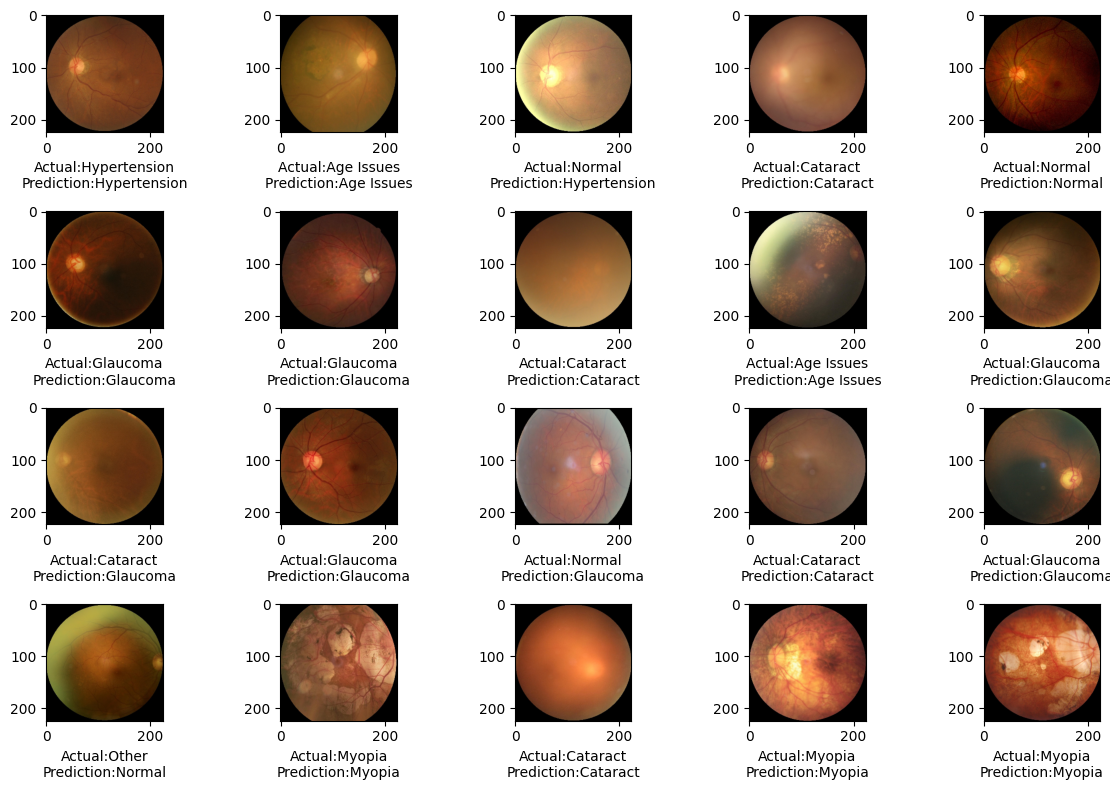

In [ ]:
# Visualizing the attempts of prediction on a random sample of the test data

plt.figure(figsize=(12,8))
for i in range(20):
    sample = random.choice(range(len(x_test)))
    image = x_test[sample]
    category = y_test[sample]
    pred_category = y_pred[sample]

    if category== 0:
        label = "Normal"
    elif category == 1 :
        label = "Cataract"
    elif category == 2:
        label = "Diabetes"
    elif category == 3:
        label = "Glaucoma"
    elif category == 4:
        label = "Hypertension"
    elif category == 5:
        label = "Myopia"
    elif category == 6:
        label = "Age Issues"
    else:
        label = "Other"

    if pred_category== 0:
        pred_label = "Normal"
    elif pred_category == 1 :
        pred_label = "Cataract"
    elif pred_category == 2:
        pred_label = "Diabetes"
    elif pred_category == 3:
        pred_label = "Glaucoma"
    elif pred_category == 4:
        pred_label = "Hypertension"
    elif pred_category == 5:
        pred_label = "Myopia"
    elif pred_category == 6:
        pred_label = "Age Issues"
    else:
        pred_label = "Other"

    plt.subplot(4,5,i+1)
    plt.imshow(image)
    plt.xlabel("Actual:{}\nPrediction:{}".format(label,pred_label))
plt.tight_layout()


In [ ]:
# Saving our model, remember that we are doing all of this to get the right parameters
# اكيد مش بعد ما جبناها هنرميها لازم نسيفها

model.save("my_VGG19_CNN_trained_model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Loading the saved model

model = load_model('my_VGG19_CNN_trained_model.h5')

In [ ]:
# After loading the model, try testing an image and see if it is classified correctly

new_image_path = 'preprocessed_images/1020_left.jpg'
new_image = cv2.imread(new_image_path)
new_image = cv2.resize(new_image, (224, 224))
new_image = new_image / 255.0

# Perform inference
predictions = model.predict(np.expand_dims(new_image, axis=0))

# Get the class with the highest probability
predicted_class = np.argmax(predictions)

# Now 'predicted_class' contains the predicted class label for the new image
print(f"Actual: {label}")
print(f"Predicted class: {pred_label}")

1/1 [==============================] - 0s 198ms/step
Actual: Myopia
Predicted class: Myopia
